## Analyze A/B Test Results
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Appendix](#appendix)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

Proportion is equal to 11.97%

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
treat_old = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
treat_old.shape[0]

1965

In [7]:
control_new = df[(df.group == 'control') & (df.landing_page == 'new_page')]
control_new.shape[0]

1928

In [8]:
treat_old.shape[0] + control_new.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# These rows are removed to feel confident in the accuracy of the data.
remove = treat_old.append(control_new).index
remove


Int64Index([   308,    327,    357,    685,    713,    776,    889,   1037,
              1106,   1376,
            ...
            293393, 293480, 293568, 293662, 293888, 293894, 293996, 294200,
            294253, 294331],
           dtype='int64', length=3893)

In [11]:
df2 = df.drop(remove)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2.user_id.duplicated().sum()

1

In [15]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2.drop(2893, inplace = True)

In [18]:
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
control_convert = df2[df2['group'] == 'control']['converted'].mean()
control_convert

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
treat_convert = df2[df2['group'] == 'treatment']['converted'].mean()
treat_convert

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
new_page = (df2['landing_page'] == 'new_page').mean()
new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

There is no evidence to say that the new treatment page leads to more conversions, due to probability of conversion for treatment group is lower than for control group.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypotheses**


$$H_0: p_{new} - p_{old} \leq 0$$


$$H_0: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
convert_mean = df2.converted.mean()
convert_mean

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
convert_mean = df2.converted.mean()
convert_mean

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.0015644412002628338

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

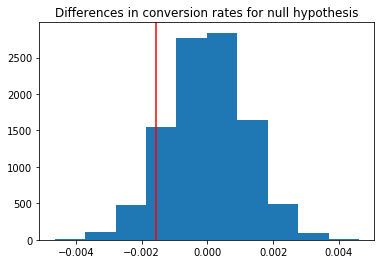

In [31]:
plt.hist(p_diffs)
plt.title('Differences in conversion rates for null hypothesis')
plt.axvline(treat_convert - control_convert, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
obs_diff = treat_convert - control_convert
(p_diffs > obs_diff).mean()

0.9033

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

*The p-value calculated is 0.9033. This value is grater than $\alpha$ level of 0.05, so we fail to reject the null hypothesis, there is no evidence to conclude there is a difference between the two values.
$\alpha$ is the probability of having a Type I error (alternative is chosen, but the null is actually true).*

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

*Calculated values align with the ones obtained during the bootstrapped hypothesis testing.*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['old_page', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:08:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

*It can be said the p-value is 0.1899 because is a two side test, still above $\alpha$ of 0.05. So, there is no evidence to reject the null hypothesis, that in the case of a logistic regression, a larger p-value suggests that changes in the predictor are not associated with changes in the response.*

*In A/B test, the null hypothesis is that old page is equal or better than the new one, and the alternative is the opposite.It is a one side test. In the testing we assume that $H_0$ is true, so the p-value is the probability of seeing a result or more extreme given that the null hypothesis is true.*

*On the other hand, in logistic regression we are seeing if there is relationship between two variables or not. So $H_0$ suggests there is no relationship, and in this case, the p-value shows us if ab_page has impact in the value of the response, in this case, conversion rate.*

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

*In this case I think it would be a good idea to consider other factors in the regression model, in order to know if they are significant in the conversion rate.
In all models it could be possible to have multicollinearity, that is a statistical phenomenon in which predictor variables in a logistic regression model are highly correlated, if there are lot of variables.*

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [39]:
#Let see the different countries we have.
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,UK,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [41]:
#Instantiate and fit the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:08:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

*In this case, p-values are again above 0.05, so we still fail to reject the null and it is conclude, there is no significant contribution of the countries to differences in conversion rates of the two pages.*

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_page'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,UK,US,CA,UK_page,US_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [43]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_page', 'US_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:08:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

*None of p-values have significant values. Therefore, we fail to reject the null hypothesis and we conclude there is not enough evidence to suggest an interaction between country and page received, that could help to predict whether there is a conversion or not.*

<a id='conclusions'></a>
## Conclusions

*To summarize, there are no sufficient evidence to suggest the new page has a better convert rates than the old one.*

<a id='appendix'></a>
## **Appendix**

*I am going to see if variable time is significant. For that, first I extract the weekday.*

In [44]:
import datetime as dt
df3 = df

In [45]:
#As "timestamp" column type is string, I transform it into datetime.
df3['timestamp'] = pd.to_datetime(df['timestamp'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [46]:
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
# I extract the weekday and create a new column for it.
df3['weekday'] = df3['timestamp'].dt.dayofweek

In [48]:
df3.head()

,user_id,timestamp,group,landing_page,converted,weekday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,5
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,3
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,6
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,5


In [49]:
# I create dummy variables for weekdays.
df3[['monday', 'tuesday', 'wendsday', 'thursday', 'friday', 'saturday', 'sunday']] = pd.get_dummies(df3['weekday'])

In [50]:
df3.head()

,user_id,timestamp,group,landing_page,converted,weekday,monday,tuesday,wendsday,thursday,friday,saturday,sunday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,5,0,0,0,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,3,0,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2,0,0,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,6,0,0,0,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,5,0,0,0,0,0,1,0


In [51]:
df3['intercept'] = 1
log_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'tuesday', 'wendsday', 'thursday', 'friday', 'saturday', 'sunday']])
results = log_mod3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366237
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294471
Method:                           MLE   Df Model:                            6
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               2.343e-05
Time:                        13:08:58   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
                                        LLR p-value:                    0.5368
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9798      0.014   -138.738      0.000      -2.008      -1.952
tuesday       -0.0183      0.020     -0.910      0.363      -0.058       0.021
wendsday      -0.0088      0.021     -0.420      0.675      -0.050       0.032
thursday      -0.0140      0.021     -0.666      0.506      -0.055       0.027
friday        -0.0413      0.021     -1.957      0.050      -0.083    5.86e-05
saturday      -0.0054      0.021     -0.258      0.796      -0.046       0.036
sunday        -0.0257      0.021     -1.223      0.221      -0.067       0.015
==============================================================================
"""

*It is interesting this result due to it shows that Friday has significant contribution to differences in conversion rates of the two pages, because its p-value is exactly 0.05. So, changes in Friday variable would be associated with changes in the response.* *

*Now, I am going to see the significance of being weekend or not.*

In [52]:
# I create new columns for weekend and weekdays, and new columns for dummy variables from weekday column.
df3["weekdayreal"] = (df3["weekday"] < 5)
df3["weekend"] = (df3["weekday"] >= 5)
df3[['wk', 'wd']] = pd.get_dummies(df3['weekdayreal'])
df3.head()

,user_id,timestamp,group,landing_page,converted,weekday,monday,tuesday,wendsday,thursday,friday,saturday,sunday,intercept,weekdayreal,weekend,wk,wd
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,5,0,0,0,0,0,1,0,1,False,True,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,3,0,0,0,1,0,0,0,1,True,False,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2,0,0,1,0,0,0,0,1,True,False,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,6,0,0,0,0,0,0,1,1,False,True,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,5,0,0,0,0,0,1,0,1,False,True,1,0


In [53]:
log_mod4 = sm.Logit(df3['converted'], df3[['intercept', 'wk']])
results = log_mod4.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366245
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294476
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               6.666e-09
Time:                        13:08:59   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
                                        LLR p-value:                    0.9698
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9958      0.007   -299.539      0.000      -2.009      -1.983
wk             0.0005      0.013      0.038      0.970      -0.024       0.025
==============================================================================
"""

*It shows the p-value is 0.970, above $\alpha$ of 0.05. So, there is no evidence to reject the null hypothesis.*